In [1]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, StratifiedKFold
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from xgboost import XGBRegressor
%matplotlib inline

In [2]:
#importing data from eda notebook
merge_df = pd.read_csv('../data/merged_fftr.csv')
month_df = pd.read_csv('../data/monthly_data.csv')

In [3]:
#making sure index is correct
merge_df = merge_df.set_index('DATE')
month_df = month_df.set_index('DATE')

In [4]:
#making sure dataframe imported correctly
merge_df.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,...,gbp_dollar,pct_recession,yen_dollar,yield_curve,1_month_ahead,2_month_ahead,3_month_ahead,1_month_back,2_month_back,3_month_back
DATE,,,,,,,,,,,,,,,,,,,,,
1987-11-09,6.8125,5.773333,17.50,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7930,0.02,134.30,1.140,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-10,6.8125,5.770000,17.75,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7865,0.02,134.55,1.180,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-11,6.8125,5.766667,17.80,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7720,0.02,135.50,1.155,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-12,6.8125,5.763333,17.85,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7575,0.02,136.45,1.130,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-13,6.8125,5.760000,17.80,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7680,0.02,135.85,1.090,7.3125,7.25,6.625,6.8125,6.8125,6.500


In [5]:
merge_df.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,...,gbp_dollar,pct_recession,yen_dollar,yield_curve,1_month_ahead,2_month_ahead,3_month_ahead,1_month_back,2_month_back,3_month_back
DATE,,,,,,,,,,,,,,,,,,,,,
1987-11-09,6.8125,5.773333,17.50,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7930,0.02,134.30,1.140,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-10,6.8125,5.770000,17.75,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7865,0.02,134.55,1.180,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-11,6.8125,5.766667,17.80,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7720,0.02,135.50,1.155,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-12,6.8125,5.763333,17.85,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7575,0.02,136.45,1.130,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-13,6.8125,5.760000,17.80,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7680,0.02,135.85,1.090,7.3125,7.25,6.625,6.8125,6.8125,6.500


In [8]:
month_df.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,...,gbp_dollar,pct_recession,yen_dollar,yield_curve,1_month_ahead,2_month_ahead,3_month_ahead,1_month_back,2_month_back,3_month_back
DATE,,,,,,,,,,,,,,,,,,,,,
1988-02-01,6.625,5.7,16.100000,3.9,6773.5,-0.559415,5073.372,418.727,542.714,60.6209,...,1.758000,0.00,129.38,1.040000,6.8125,6.8125,6.8125,6.50,6.7500,6.7500
1988-03-01,6.500,5.7,14.180000,3.9,6804.3,-0.559415,5073.372,418.727,542.714,60.7591,...,1.777500,0.00,128.27,1.040000,6.6250,6.8125,6.8125,6.75,6.7500,7.2500
1988-04-01,6.750,5.4,15.620000,4.9,6830.1,-0.037442,5190.036,439.471,546.098,61.1144,...,1.890000,0.02,124.00,1.145000,6.5000,6.6250,6.8125,6.75,7.2500,7.5000
1988-05-01,6.750,5.6,16.166667,4.9,6841.7,-0.037442,5190.036,439.471,546.098,60.9952,...,1.873833,0.12,124.94,1.153333,6.7500,6.5000,6.6250,7.25,7.5000,7.6875
1988-06-01,7.250,5.4,16.330000,4.9,6868.5,-0.037442,5190.036,439.471,546.098,61.1697,...,1.823500,0.00,125.20,0.940000,6.7500,6.7500,6.5000,7.50,7.6875,8.1250


In [9]:
X = merge_df.drop(columns = ['1_month_ahead', '2_month_ahead', '3_month_ahead'])
y_1 = merge_df['1_month_ahead']
y_2 = merge_df['2_month_ahead']
y_3 = merge_df['3_month_ahead']
X_month = month_df.drop(columns = ['1_month_ahead', '2_month_ahead', '3_month_ahead'])
y_month_1 = month_df['1_month_ahead']
y_month_2 = month_df['2_month_ahead']
y_month_3 = month_df['3_month_ahead']

In [10]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y_1, random_state=42, test_size=0.25)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y_2, random_state=42, test_size=0.25)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y_3, random_state=42, test_size=0.25)
X_train_month_1, X_test_month_1, y_train_month_1, y_test_month_1 = train_test_split(X_month, y_month_1, random_state=42, test_size=0.25)
X_train_month_2, X_test_month_2, y_train_month_2, y_test_month_2 = train_test_split(X_month, y_month_2, random_state=42, test_size=0.25)
X_train_month_3, X_test_month_3, y_train_month_3, y_test_month_3 = train_test_split(X_month, y_month_3, random_state=42, test_size=0.25)

In [ ]:
#going to run a gridsearch for 1,2,3 months out with both day and month dataframes, going to use random forest as I think that is the
#optimal archetecture, as well as trying xg boosting

In [11]:
grid = { 
    'n_estimators': [400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [5,6,7]
}
print(datetime.now())
rfr_CV = GridSearchCV(estimator=RandomForestRegressor(criterion='squared_error'), param_grid=grid, cv= 5)
rfr_CV.fit(X_train_month_1, y_train_month_1)
print(datetime.now())

2024-03-01 12:06:21.136039
2024-03-01 12:06:38.427353


In [12]:
rfr_CV.best_params_

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 400}

In [13]:
best_rfr_model = rfr_CV.best_estimator_

In [14]:
prediction = best_rfr_model.predict(X_test_month_1)
mse = mean_squared_error(y_test_month_1, prediction)
rmse = mse**.5
print(mse)
print(rmse)

0.08905938848867281
0.29842819653758057


In [15]:
grid = { 
    'n_estimators': [400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [5,6,7]
}
print(datetime.now())
rfr_CV = GridSearchCV(estimator=RandomForestRegressor(criterion='squared_error'), param_grid=grid, cv= 5)
rfr_CV.fit(X_train_month_2, y_train_month_2)
print(datetime.now())

2024-03-01 12:06:38.484397
2024-03-01 12:06:56.295784


In [16]:
rfr_CV.best_params_

{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 500}

In [17]:
best_rfr_model = rfr_CV.best_estimator_

In [18]:
prediction = best_rfr_model.predict(X_test_month_2)
mse = mean_squared_error(y_test_month_2, prediction)
rmse = mse**.5
print(mse)
print(rmse)

0.09459101329365595
0.30755652048632615


In [19]:
grid = { 
    'n_estimators': [600,700],
    'max_features': ['sqrt','log2'],
    'max_depth' : [11,12]
}
print(datetime.now())
rfr_CV = GridSearchCV(estimator=RandomForestRegressor(criterion='squared_error'), param_grid=grid, cv= 5)
rfr_CV.fit(X_train_month_3, y_train_month_3)
print(datetime.now())

2024-03-01 12:06:56.502884
2024-03-01 12:07:21.172724


In [20]:
rfr_CV.best_params_

{'max_depth': 12, 'max_features': 'log2', 'n_estimators': 600}

In [21]:
best_rfr_model = rfr_CV.best_estimator_

In [22]:
prediction = best_rfr_model.predict(X_test_month_3)
mse = mean_squared_error(y_test_month_3, prediction)
rmse = mse**.5
print(mse)
print(rmse)

0.11281951973198799
0.3358861707959826


In [23]:
grid = { 
    'n_estimators': [600,700],
    'max_features': ['sqrt','log2'],
    'max_depth' : [11,12]
}
print(datetime.now())
rfr_CV = GridSearchCV(estimator=RandomForestRegressor(criterion='squared_error'), param_grid=grid, cv= 5)
rfr_CV.fit(X_train_1, y_train_1)
print(datetime.now())

2024-03-01 12:07:21.717479
2024-03-01 12:11:25.778228


In [24]:
best_rfr_model = rfr_CV.best_estimator_

In [25]:
prediction = best_rfr_model.predict(X_test_1)
mse = mean_squared_error(y_test_1, prediction)
rmse = mse**.5
print(mse)
print(rmse)

0.001391142938123102
0.03729802860907131


In [26]:
grid = { 
    'n_estimators': [600,700],
    'max_features': ['sqrt','log2'],
    'max_depth' : [11,12]
}
print(datetime.now())
rfr_CV = GridSearchCV(estimator=RandomForestRegressor(criterion='squared_error'), param_grid=grid, cv= 5)
rfr_CV.fit(X_train_2, y_train_2)
print(datetime.now())

2024-03-01 12:11:26.047097
2024-03-01 12:16:30.325129


In [27]:
best_rfr_model = rfr_CV.best_estimator_

In [28]:
prediction = best_rfr_model.predict(X_test_2)
mse = mean_squared_error(y_test_2, prediction)
rmse = mse**.5
print(mse)
print(rmse)

0.0020739826209284196
0.04554099934046704


In [29]:
grid = { 
    'n_estimators': [1000, 1200],
    'max_features': ['sqrt','log2'],
    'max_depth' : [13, 14]
}
print(datetime.now())
rfr_CV = GridSearchCV(estimator=RandomForestRegressor(criterion='squared_error'), param_grid=grid, cv= 5)
rfr_CV.fit(X_train_3, y_train_3)
print(datetime.now())

2024-03-01 12:16:31.151843
2024-03-01 12:25:53.619984


In [30]:
best_rfr_model = rfr_CV.best_estimator_

In [32]:
y_pred = best_rfr_model.predict(X_test_3)
rfr_full_pred = best_rfr_model.predict(X)

In [33]:
MAE = mean_absolute_error(y_test_3, 
                          y_pred)
print(MAE)

0.012398496272912347


In [34]:
mse = mean_squared_error(y_test_3, y_pred)
rmse = mse**.5
print(mse)
print(rmse)

0.0020706930499956844
0.04550486842081498


In [35]:
rfr_CV.best_params_

{'max_depth': 14, 'max_features': 'log2', 'n_estimators': 1200}

In [36]:
r2_score(y_test_3, y_pred)

0.9996946924271313

In [37]:
X_train_3.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,...,m2_velo,nasdaq,pci,gbp_dollar,pct_recession,yen_dollar,yield_curve,1_month_back,2_month_back,3_month_back
DATE,,,,,,,,,,,,,,,,,,,,,
1998-10-26,5.00,4.419355,12.74,1.3,9337.5,2.026079,9293.991,966.337,1145.000,86.5967,...,2.140,1724.980000,2.535056,1.6830,0.00,118.84,0.50,4.75,4.75,4.75
2009-08-01,0.25,9.600000,71.02,1.4,12194.8,-5.287064,14448.882,1594.725,2018.722,86.6617,...,1.711,1988.536667,1.757047,1.6794,0.76,94.77,2.42,0.25,0.25,0.25
2023-01-05,4.50,3.425806,76.73,5.0,16601.9,-0.060974,26813.601,3064.804,3890.491,102.5478,...,1.273,10305.240000,6.487554,1.1902,0.08,133.57,-0.74,4.75,4.75,5.00
1997-10-02,5.50,4.696774,20.08,1.3,8834.8,1.414139,8765.907,968.330,1085.344,82.7657,...,2.184,1702.410000,2.618901,1.6135,0.00,121.80,0.28,5.50,5.50,5.50
2003-03-07,1.25,5.919355,34.47,1.2,10696.5,-2.560957,11174.129,1004.201,1529.463,91.0059,...,1.915,1305.290000,2.619135,1.6020,0.60,116.47,2.24,1.25,1.25,1.25


In [38]:
grid = {'max_depth': [7,10], 'learning_rate': [.1],
        'n_estimators': [600, 700]}
xgb_cv = GridSearchCV(estimator = XGBRegressor(objective='reg:squarederror'), scoring='neg_mean_absolute_error',
                  param_grid = grid, cv = 5)
xgb_cv.fit(X_train_3, y_train_3);

In [39]:
xgb_cv.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
best_xgb_model = xgb_cv.best_estimator_
best_xgb_model.fit(X_train_3, y_train_3);
y_pred = best_xgb_model.predict(X_test_3)

In [41]:
MAE = mean_absolute_error(y_test_3, 
                          y_pred)

In [42]:
print(MAE)

0.011377812133701837


In [43]:
RMSE = np.sqrt(mean_squared_error(y_test_3,
                                  y_pred))
print(RMSE)

0.05160645116122094


In [44]:
r2_score(y_test_3, y_pred)

0.9996073280849397

In [45]:
xgb_full_pred = best_xgb_model.predict(X)

In [59]:
# making linreg model for comparison
linreg = LinearRegression()
linreg.fit(X_train_3, y_train_3)
y_pred = linreg.predict(X_test_3)
linreg_full_pred = linreg.predict(X)
linreg.score(X_test_3,y_test_3)

0.9840666618495315

In [47]:
MAE = mean_absolute_error(y_test_3, 
                          y_pred)
MAE

0.22211242346078305

In [48]:
#pretty good, but the improvement of over 1% for the random forest is amazing improvement, most notably the drop of MAE from 

In [49]:
#gonna make a taylor rule baseline linreg model to compare to theory

In [50]:
merge_df.columns

Index(['FFTR', 'UNRATE', 'Oil', 'PCE', 'DispInc', 'gdp_gap', 'GDP', 'EXPGS',
       'IMPGS', 'ind_prod', 'm2', 'm2_velo', 'nasdaq', 'pci', 'gbp_dollar',
       'pct_recession', 'yen_dollar', 'yield_curve', '1_month_ahead',
       '2_month_ahead', '3_month_ahead', '1_month_back', '2_month_back',
       '3_month_back'],
      dtype='object')

In [51]:
X_train_taylor = X_train_3.drop(columns = ['UNRATE', 'Oil', 'PCE', 'DispInc', 'GDP', 'EXPGS', 'IMPGS', 'ind_prod', 'm2', 'm2_velo', 'nasdaq', 'gbp_dollar', 'pct_recession', 'yen_dollar', 'yield_curve', '1_month_back', '2_month_back', '3_month_back'])
X_train_taylor.head()

,FFTR,gdp_gap,pci
DATE,,,
1998-10-26,5.00,2.026079,2.535056
2009-08-01,0.25,-5.287064,1.757047
2023-01-05,4.50,-0.060974,6.487554
1997-10-02,5.50,1.414139,2.618901
2003-03-07,1.25,-2.560957,2.619135


In [52]:
X_test_taylor = X_test_3.drop(columns = ['UNRATE', 'Oil', 'PCE', 'DispInc', 'GDP', 'EXPGS', 'IMPGS', 'ind_prod', 'm2', 'm2_velo', 'nasdaq', 'gbp_dollar', 'pct_recession', 'yen_dollar', 'yield_curve', '1_month_back', '2_month_back', '3_month_back'])
X_test_taylor.head()

,FFTR,gdp_gap,pci
DATE,,,
2010-07-09,0.25,-3.495702,0.744071
2001-11-13,2.00,-1.871609,3.601999
2010-09-20,0.25,-3.495702,0.663868
2003-09-12,1.00,-1.287599,2.174311
1997-05-17,5.50,1.251815,2.870203


In [53]:
X_taylor = X.drop(columns = ['UNRATE', 'Oil', 'PCE', 'DispInc', 'GDP', 'EXPGS', 'IMPGS', 'ind_prod', 'm2', 'm2_velo', 'nasdaq', 'gbp_dollar', 'pct_recession', 'yen_dollar', 'yield_curve', '1_month_back', '2_month_back', '3_month_back'])

In [54]:
linreg = LinearRegression()
linreg.fit(X_train_taylor, y_train_3)
y_pred = linreg.predict(X_test_taylor)
taylor_full_pred = linreg.predict(X_taylor)
linreg.score(X_test_taylor,y_test_3)

0.9689692203358007

In [55]:
MAE = mean_absolute_error(y_test_3, 
                          y_pred)
MAE

0.31364960510125856

In [56]:
r2_score(y_test_3, y_pred)

0.9689692203358007

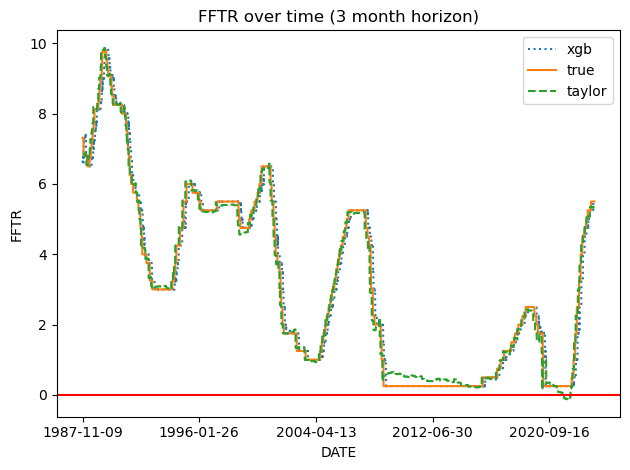

In [72]:
plt.plot(xgb_full_pred, linestyle = 'dotted', label = 'xgb')
plt.plot(y_1, linestyle = 'solid', label = 'true')
plt.plot(taylor_full_pred, linestyle = 'dashed', label = 'taylor')
plt.ylabel('FFTR')
plt.title('FFTR over time (3 month horizon)')
plt.xlabel('DATE')
plt.xticks(np.arange(0, 14000, 3000))
plt.axhline(y = 0, color = 'r', linestyle = '-') 
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('../images/accuracy_by_model.png')
plt.show()

In [67]:
importances = best_rfr_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rfr_model.estimators_], axis=0)

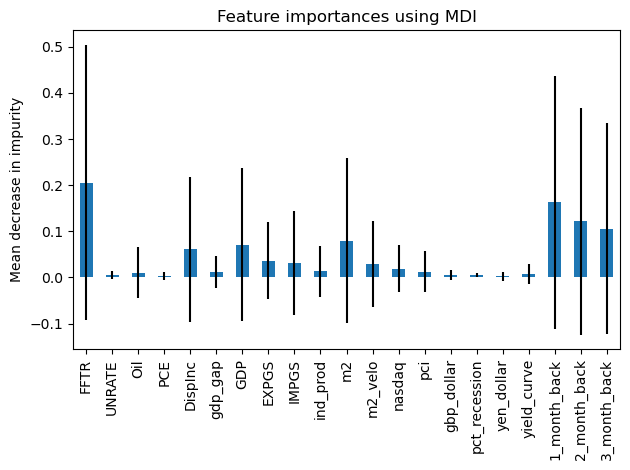

In [71]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()